### NB: Every line of code that has been commented out does not contribute to the best submission and hence can be ignored

In [12]:
# import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

%matplotlib inline

In [2]:
date_columns = list(pd.read_csv('Train.csv').columns[2:6])
train = pd.read_csv('Train.csv', parse_dates=date_columns, dayfirst=True)

In [3]:
# view general structure of the data
train.head(10)

,Loan_ID,Loan Category Code,ActualFirstDisbursementDate,ApprovalDate,FirstInstalmentDate,MaturityDate,LoanAmount,BillingFrequency,LoanInterestrate,NumberOfDependency,OtherLoansBalance,MaritalStatus,Gender,BirthDate,Target
0,005DTM4,0,2018-12-24,2018-12-28,2019-01-30,2020-12-30,17615.64,Monthly,71.21,3.0,2,Married,Female,Nov 1990,0
1,00E1LTS,0,2019-01-03,2019-01-24,2019-01-30,2020-12-30,12330.92,Monthly,71.21,3.0,1,Married,Male,Nov 1975,0
2,00T6VP0,0,2019-03-29,2019-03-29,2019-04-30,2021-03-30,17967.87,Monthly,71.21,2.0,0,Un-Married,Male,Mar 1966,0
3,00W9TT0,0,2019-02-14,2019-02-27,2019-03-30,2020-08-30,10786.73,Monthly,71.21,3.0,0,Married,Male,Sep 1980,0
4,0115VRN,0,2018-10-29,2018-10-31,2018-11-30,2020-10-30,20257.92,Monthly,71.21,3.0,4,Married,Male,Apr 1969,0
5,01A43YO,0,2019-04-26,2019-04-30,2019-05-30,2020-10-30,13476.03,Monthly,71.21,3.0,0,Married,Male,Jan 1963,0
6,01HD179,1,2019-07-12,2019-07-29,2019-08-30,2020-07-30,7718.47,Monthly,82.17,3.0,5,Married,Male,Dec 1960,1
7,01OC3FW,1,2020-01-15,2020-01-15,2020-02-28,2021-01-28,19534.42,Monthly,147.91,NaN,0,Un-Married,Male,Jan 1977,0
8,01XBE6J,0,2019-05-30,2019-05-31,2019-06-30,2020-05-30,19764.81,Monthly,71.21,3.0,0,Married,Male,Dec 1966,0
9,02IJDG0,1,2019-08-10,2019-08-10,2019-09-30,2020-08-30,5788.85,Monthly,82.17,NaN,0,Un-Married,Male,Jun 1974,1


In [4]:
train.info()
# summary: null values only exist in the 'NumberOfDependency' column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8315 entries, 0 to 8314
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Loan_ID                      8315 non-null   object        
 1   Loan Category Code           8315 non-null   int64         
 2   ActualFirstDisbursementDate  8315 non-null   datetime64[ns]
 3   ApprovalDate                 8315 non-null   datetime64[ns]
 4   FirstInstalmentDate          8315 non-null   datetime64[ns]
 5   MaturityDate                 8315 non-null   datetime64[ns]
 6   LoanAmount                   8315 non-null   float64       
 7   BillingFrequency             8315 non-null   object        
 8   LoanInterestrate             8315 non-null   float64       
 9   NumberOfDependency           7271 non-null   float64       
 10  OtherLoansBalance            8315 non-null   int64         
 11  MaritalStatus                8315 non-null 

In [5]:
# Feature Generation: Extract year, month and day from each individual date column

train['ApprovalYear'] = pd.DatetimeIndex(train['ApprovalDate']).year
train['ApprovalMonth'] = pd.DatetimeIndex(train['ApprovalDate']).month
train['ApprovalDay'] = pd.DatetimeIndex(train['ApprovalDate']).day

train['MaturityYear'] = pd.DatetimeIndex(train['MaturityDate']).year
train['MaturityMonth'] = pd.DatetimeIndex(train['MaturityDate']).month
train['MaturityDay'] = pd.DatetimeIndex(train['MaturityDate']).day

train['ActualFirstDisbursementYear'] = pd.DatetimeIndex(train['ActualFirstDisbursementDate']).year
train['ActualFirstDisbursementMonth'] = pd.DatetimeIndex(train['ActualFirstDisbursementDate']).month
train['ActualFirstDisbursementDay'] = pd.DatetimeIndex(train['ActualFirstDisbursementDate']).day

In [6]:
# impute missing values in 'NumberOfDependency' column using K-Nearest Neighbours Imputer

imputer = KNNImputer(n_neighbors=2, weights='uniform')

train['NumberOfDependency'] = imputer.fit_transform(np.array(train['NumberOfDependency']).reshape(-1,1))
train['NumberOfDependency'] = train['NumberOfDependency'].apply(np.ceil)

<AxesSubplot:>

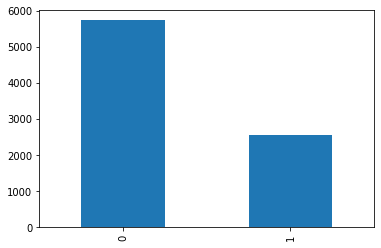

In [7]:
# inspect the balance of the data for the target variable
train['Target'].value_counts().plot(kind='bar')

In [8]:
# extract birth year, month and day from BirthDate column

train['BirthDate'] = train['BirthDate'].apply(lambda x: x.split())

month = []
year = []
 
for i, j in train['BirthDate']:
    month.append(i)
    year.append(j)
    
train['BirthMonth'], train['BirthYear'] = month, year

In [9]:
# drop the original columns from which additional features were extracted from

train = train.drop(columns=['ActualFirstDisbursementDate', 'ApprovalDate', 'FirstInstalmentDate', 'MaturityDate'])
train = train.drop(columns=['BirthDate'])

In [10]:
# drop Loan_ID and BillingFrequency (it does not contribute to the model since all samples have the same value)

train = train.drop(columns=['Loan_ID', 'BillingFrequency'])

In [11]:
# inspect final data before transformation
train

,Loan Category Code,LoanAmount,LoanInterestrate,NumberOfDependency,OtherLoansBalance,MaritalStatus,Gender,Target,ApprovalYear,ApprovalMonth,ApprovalDay,MaturityYear,MaturityMonth,MaturityDay,ActualFirstDisbursementYear,ActualFirstDisbursementMonth,ActualFirstDisbursementDay,BirthMonth,BirthYear
0,0,17615.64,71.21,3.0,2,Married,Female,0,2018,12,28,2020,12,30,2018,12,24,Nov,1990
1,0,12330.92,71.21,3.0,1,Married,Male,0,2019,1,24,2020,12,30,2019,1,3,Nov,1975
2,0,17967.87,71.21,2.0,0,Un-Married,Male,0,2019,3,29,2021,3,30,2019,3,29,Mar,1966
3,0,10786.73,71.21,3.0,0,Married,Male,0,2019,2,27,2020,8,30,2019,2,14,Sep,1980
4,0,20257.92,71.21,3.0,4,Married,Male,0,2018,10,31,2020,10,30,2018,10,29,Apr,1969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8310,0,12577.56,71.21,3.0,1,Married,Male,1,2019,3,20,2020,3,30,2019,3,15,Mar,1983
8311,0,26951.89,71.21,3.0,1,Married,Female,0,2019,4,30,2021,4,30,2019,4,24,Apr,1976
8312,1,38831.47,147.91,3.0,5,Married,Male,0,2020,1,30,2021,1,31,2020,1,29,Mar,1969
8313,0,5284.73,71.21,3.0,3,Un-Married,Female,0,2019,1,31,2021,1,31,2019,1,31,Jul,1970


In [13]:
# feature transformers for numerical and categorical variables

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe',OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [14]:
train.columns

Index(['Loan Category Code', 'LoanAmount', 'LoanInterestrate',
       'NumberOfDependency', 'OtherLoansBalance', 'MaritalStatus', 'Gender',
       'Target', 'ApprovalYear', 'ApprovalMonth', 'ApprovalDay',
       'MaturityYear', 'MaturityMonth', 'MaturityDay',
       'ActualFirstDisbursementYear', 'ActualFirstDisbursementMonth',
       'ActualFirstDisbursementDay', 'BirthMonth', 'BirthYear'],
      dtype='object')

In [15]:
# define the numeric and categorical features
numeric_features = ['LoanAmount']
categorical_features = ['Loan Category Code', 'LoanInterestrate', 'NumberOfDependency', 
                        'OtherLoansBalance', 'MaritalStatus', 'Gender', 'ApprovalYear', 'ApprovalMonth',
                       'ApprovalDay', 'MaturityYear', 'MaturityMonth', 'MaturityDay',
                        'ActualFirstDisbursementYear', 'ActualFirstDisbursementMonth',
                        'ActualFirstDisbursementDay', 'BirthMonth', 'BirthYear']

In [16]:
# define column transformer object
from sklearn.compose import ColumnTransformer
 
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

In [17]:
# ensuring that values for categorical features are of type str, to aid the encoding process
for category in categorical_features:
    if train[category].dtype != 'object':
         train[category] = train[category].apply(lambda x: str(x))

In [18]:
# check that the datatypes have been successfully updated
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8315 entries, 0 to 8314
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan Category Code            8315 non-null   object 
 1   LoanAmount                    8315 non-null   float64
 2   LoanInterestrate              8315 non-null   object 
 3   NumberOfDependency            8315 non-null   object 
 4   OtherLoansBalance             8315 non-null   object 
 5   MaritalStatus                 8315 non-null   object 
 6   Gender                        8315 non-null   object 
 7   Target                        8315 non-null   int64  
 8   ApprovalYear                  8315 non-null   object 
 9   ApprovalMonth                 8315 non-null   object 
 10  ApprovalDay                   8315 non-null   object 
 11  MaturityYear                  8315 non-null   object 
 12  MaturityMonth                 8315 non-null   object 
 13  Mat

In [19]:
# prepare data for modelling
X = train.drop(columns=['Target'])
y = train['Target']

In [20]:
# generate train and test splits with a 20% split ratio

from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [ ]:
# X_train = preprocessor.fit_transform(X_train)

In [ ]:
# X_test = preprocessor.transform(X_test)

## XGBoost

In [ ]:
# params = {'objective': 'binary:logistic',
#           'max_depth': 20,
#           'alpha': 10,
#           'learning_rate': 0.1,
#           'n_estimators': 100}
 
# clf = XGBClassifier(**params)

In [ ]:
# clf.fit(X_train, y_train)

In [ ]:
# y_pred = clf.predict(X_test)
# print("Accuracy: {:.2f}%".format(100*accuracy_score(y_test, y_pred)))
# print("ROC AUC Score: {:.2f}%".format(100*roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))

In [ ]:
# sns.heatmap(confusion_matrix(y_pred,y_test), annot=True, fmt='.0f', cmap='Blues')

In [ ]:
# # cross validation
# from xgboost import DMatrix, cv
 
# data_dmatrix = DMatrix(data=preprocessor.transform(X),label=y)
 
# params = {'objective': 'binary:logistic',
#           'max_depth': 20,
#           'alpha': 5,
#           'learning_rate': 0.1}
 
# xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=500, 
#             metrics='auc', as_pandas=True, seed=0,verbose_eval=True)

In [ ]:
# params = {'objective': 'binary:logistic',
#           'max_depth': 20,
#           'alpha': 1,
#           'learning_rate': 0.1,
#           'n_estimators': 500,
#           'colsample_bytree':  0.9,
#           'verbosity': 1}
 
# clf = XGBClassifier(**params)

In [ ]:
# clf.fit(preprocessor.transform(X), y)

In [ ]:
# accuracy_score(y, clf.predict(preprocessor.transform(X)))

## Catboost Model

In [22]:
# define the baseline catboost model

params = {'loss_function': 'Logloss',
          'eval_metric': 'AUC',
          'cat_features': categorical_features,
          'random_seed': 0}

cat_clf = CatBoostClassifier(**params)
 
cat_clf.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        verbose=True)

Learning rate set to 0.050603
0:	test: 0.7597580	best: 0.7597580 (0)	total: 257ms	remaining: 4m 16s
1:	test: 0.7914282	best: 0.7914282 (1)	total: 304ms	remaining: 2m 31s
2:	test: 0.8001590	best: 0.8001590 (2)	total: 364ms	remaining: 2m
3:	test: 0.8038825	best: 0.8038825 (3)	total: 407ms	remaining: 1m 41s
4:	test: 0.8126414	best: 0.8126414 (4)	total: 458ms	remaining: 1m 31s
5:	test: 0.8153198	best: 0.8153198 (5)	total: 511ms	remaining: 1m 24s
6:	test: 0.8163878	best: 0.8163878 (6)	total: 562ms	remaining: 1m 19s
7:	test: 0.8161786	best: 0.8163878 (6)	total: 613ms	remaining: 1m 16s
8:	test: 0.8175841	best: 0.8175841 (8)	total: 671ms	remaining: 1m 13s
9:	test: 0.8164745	best: 0.8175841 (8)	total: 736ms	remaining: 1m 12s
10:	test: 0.8189591	best: 0.8189591 (10)	total: 785ms	remaining: 1m 10s
11:	test: 0.8203246	best: 0.8203246 (11)	total: 817ms	remaining: 1m 7s
12:	test: 0.8203672	best: 0.8203672 (12)	total: 860ms	remaining: 1m 5s
13:	test: 0.8200279	best: 0.8203672 (12)	total: 936ms	remain

116:	test: 0.8385116	best: 0.8385201 (115)	total: 6.41s	remaining: 48.4s
117:	test: 0.8385661	best: 0.8385661 (117)	total: 6.47s	remaining: 48.4s
118:	test: 0.8384861	best: 0.8385661 (117)	total: 6.56s	remaining: 48.6s
119:	test: 0.8386681	best: 0.8386681 (119)	total: 6.68s	remaining: 49s
120:	test: 0.8386681	best: 0.8386681 (119)	total: 6.68s	remaining: 48.6s
121:	test: 0.8386256	best: 0.8386681 (119)	total: 6.76s	remaining: 48.6s
122:	test: 0.8387922	best: 0.8387922 (122)	total: 6.81s	remaining: 48.6s
123:	test: 0.8387871	best: 0.8387922 (122)	total: 6.86s	remaining: 48.5s
124:	test: 0.8388637	best: 0.8388637 (124)	total: 6.92s	remaining: 48.4s
125:	test: 0.8388467	best: 0.8388637 (124)	total: 6.97s	remaining: 48.4s
126:	test: 0.8388433	best: 0.8388637 (124)	total: 7.04s	remaining: 48.4s
127:	test: 0.8388603	best: 0.8388637 (124)	total: 7.1s	remaining: 48.4s
128:	test: 0.8391715	best: 0.8391715 (128)	total: 7.16s	remaining: 48.3s
129:	test: 0.8391460	best: 0.8391715 (128)	total: 7.21

229:	test: 0.8397480	best: 0.8403823 (219)	total: 12.4s	remaining: 41.5s
230:	test: 0.8396953	best: 0.8403823 (219)	total: 12.4s	remaining: 41.4s
231:	test: 0.8397650	best: 0.8403823 (219)	total: 12.5s	remaining: 41.3s
232:	test: 0.8397004	best: 0.8403823 (219)	total: 12.6s	remaining: 41.3s
233:	test: 0.8397803	best: 0.8403823 (219)	total: 12.6s	remaining: 41.3s
234:	test: 0.8397242	best: 0.8403823 (219)	total: 12.7s	remaining: 41.2s
235:	test: 0.8398245	best: 0.8403823 (219)	total: 12.7s	remaining: 41.2s
236:	test: 0.8399673	best: 0.8403823 (219)	total: 12.8s	remaining: 41.1s
237:	test: 0.8399793	best: 0.8403823 (219)	total: 12.8s	remaining: 41s
238:	test: 0.8399673	best: 0.8403823 (219)	total: 12.9s	remaining: 41s
239:	test: 0.8399452	best: 0.8403823 (219)	total: 12.9s	remaining: 40.9s
240:	test: 0.8399163	best: 0.8403823 (219)	total: 13s	remaining: 40.8s
241:	test: 0.8400337	best: 0.8403823 (219)	total: 13s	remaining: 40.8s
242:	test: 0.8400116	best: 0.8403823 (219)	total: 13.1s	rem

344:	test: 0.8405558	best: 0.8405949 (258)	total: 18.7s	remaining: 35.6s
345:	test: 0.8405592	best: 0.8405949 (258)	total: 18.8s	remaining: 35.5s
346:	test: 0.8405660	best: 0.8405949 (258)	total: 18.8s	remaining: 35.5s
347:	test: 0.8404843	best: 0.8405949 (258)	total: 18.9s	remaining: 35.4s
348:	test: 0.8405047	best: 0.8405949 (258)	total: 18.9s	remaining: 35.3s
349:	test: 0.8404078	best: 0.8405949 (258)	total: 19s	remaining: 35.3s
350:	test: 0.8403806	best: 0.8405949 (258)	total: 19s	remaining: 35.2s
351:	test: 0.8403908	best: 0.8405949 (258)	total: 19.1s	remaining: 35.1s
352:	test: 0.8403160	best: 0.8405949 (258)	total: 19.2s	remaining: 35.1s
353:	test: 0.8403925	best: 0.8405949 (258)	total: 19.2s	remaining: 35.1s
354:	test: 0.8404231	best: 0.8405949 (258)	total: 19.3s	remaining: 35s
355:	test: 0.8403942	best: 0.8405949 (258)	total: 19.3s	remaining: 35s
356:	test: 0.8404418	best: 0.8405949 (258)	total: 19.4s	remaining: 34.9s
357:	test: 0.8404605	best: 0.8405949 (258)	total: 19.4s	rem

460:	test: 0.8418329	best: 0.8419179 (457)	total: 25.1s	remaining: 29.4s
461:	test: 0.8418584	best: 0.8419179 (457)	total: 25.2s	remaining: 29.3s
462:	test: 0.8418074	best: 0.8419179 (457)	total: 25.3s	remaining: 29.3s
463:	test: 0.8417921	best: 0.8419179 (457)	total: 25.3s	remaining: 29.2s
464:	test: 0.8418329	best: 0.8419179 (457)	total: 25.4s	remaining: 29.2s
465:	test: 0.8418057	best: 0.8419179 (457)	total: 25.5s	remaining: 29.2s
466:	test: 0.8417343	best: 0.8419179 (457)	total: 25.5s	remaining: 29.1s
467:	test: 0.8417581	best: 0.8419179 (457)	total: 25.6s	remaining: 29.1s
468:	test: 0.8417666	best: 0.8419179 (457)	total: 25.6s	remaining: 29s
469:	test: 0.8417377	best: 0.8419179 (457)	total: 25.7s	remaining: 29s
470:	test: 0.8418329	best: 0.8419179 (457)	total: 25.7s	remaining: 28.9s
471:	test: 0.8420030	best: 0.8420030 (471)	total: 25.8s	remaining: 28.9s
472:	test: 0.8419587	best: 0.8420030 (471)	total: 25.8s	remaining: 28.8s
473:	test: 0.8419502	best: 0.8420030 (471)	total: 25.9s

573:	test: 0.8425625	best: 0.8428669 (550)	total: 31.4s	remaining: 23.3s
574:	test: 0.8426135	best: 0.8428669 (550)	total: 31.5s	remaining: 23.3s
575:	test: 0.8426407	best: 0.8428669 (550)	total: 31.5s	remaining: 23.2s
576:	test: 0.8427988	best: 0.8428669 (550)	total: 31.6s	remaining: 23.1s
577:	test: 0.8427580	best: 0.8428669 (550)	total: 31.6s	remaining: 23.1s
578:	test: 0.8427223	best: 0.8428669 (550)	total: 31.7s	remaining: 23s
579:	test: 0.8427291	best: 0.8428669 (550)	total: 31.7s	remaining: 23s
580:	test: 0.8428243	best: 0.8428669 (550)	total: 31.8s	remaining: 22.9s
581:	test: 0.8428754	best: 0.8428754 (581)	total: 31.8s	remaining: 22.9s
582:	test: 0.8429230	best: 0.8429230 (582)	total: 31.9s	remaining: 22.8s
583:	test: 0.8429111	best: 0.8429230 (582)	total: 31.9s	remaining: 22.8s
584:	test: 0.8429043	best: 0.8429230 (582)	total: 32s	remaining: 22.7s
585:	test: 0.8428703	best: 0.8429230 (582)	total: 32.1s	remaining: 22.7s
586:	test: 0.8428567	best: 0.8429230 (582)	total: 32.1s	r

687:	test: 0.8421254	best: 0.8431305 (600)	total: 37.8s	remaining: 17.1s
688:	test: 0.8421781	best: 0.8431305 (600)	total: 37.8s	remaining: 17.1s
689:	test: 0.8421407	best: 0.8431305 (600)	total: 37.9s	remaining: 17s
690:	test: 0.8422036	best: 0.8431305 (600)	total: 37.9s	remaining: 17s
691:	test: 0.8422921	best: 0.8431305 (600)	total: 38s	remaining: 16.9s
692:	test: 0.8422802	best: 0.8431305 (600)	total: 38s	remaining: 16.8s
693:	test: 0.8423023	best: 0.8431305 (600)	total: 38.1s	remaining: 16.8s
694:	test: 0.8420812	best: 0.8431305 (600)	total: 38.1s	remaining: 16.7s
695:	test: 0.8420625	best: 0.8431305 (600)	total: 38.2s	remaining: 16.7s
696:	test: 0.8420710	best: 0.8431305 (600)	total: 38.2s	remaining: 16.6s
697:	test: 0.8420506	best: 0.8431305 (600)	total: 38.3s	remaining: 16.6s
698:	test: 0.8421288	best: 0.8431305 (600)	total: 38.3s	remaining: 16.5s
699:	test: 0.8420727	best: 0.8431305 (600)	total: 38.4s	remaining: 16.5s
700:	test: 0.8421101	best: 0.8431305 (600)	total: 38.5s	rem

802:	test: 0.8424485	best: 0.8431305 (600)	total: 43.9s	remaining: 10.8s
803:	test: 0.8424026	best: 0.8431305 (600)	total: 44s	remaining: 10.7s
804:	test: 0.8423941	best: 0.8431305 (600)	total: 44s	remaining: 10.7s
805:	test: 0.8423499	best: 0.8431305 (600)	total: 44.1s	remaining: 10.6s
806:	test: 0.8423584	best: 0.8431305 (600)	total: 44.2s	remaining: 10.6s
807:	test: 0.8422325	best: 0.8431305 (600)	total: 44.2s	remaining: 10.5s
808:	test: 0.8423159	best: 0.8431305 (600)	total: 44.3s	remaining: 10.5s
809:	test: 0.8423176	best: 0.8431305 (600)	total: 44.3s	remaining: 10.4s
810:	test: 0.8422495	best: 0.8431305 (600)	total: 44.4s	remaining: 10.3s
811:	test: 0.8422802	best: 0.8431305 (600)	total: 44.5s	remaining: 10.3s
812:	test: 0.8423788	best: 0.8431305 (600)	total: 44.5s	remaining: 10.2s
813:	test: 0.8423941	best: 0.8431305 (600)	total: 44.6s	remaining: 10.2s
814:	test: 0.8423635	best: 0.8431305 (600)	total: 44.7s	remaining: 10.1s
815:	test: 0.8423584	best: 0.8431305 (600)	total: 44.7s

916:	test: 0.8424706	best: 0.8431305 (600)	total: 50.3s	remaining: 4.55s
917:	test: 0.8425182	best: 0.8431305 (600)	total: 50.3s	remaining: 4.49s
918:	test: 0.8425029	best: 0.8431305 (600)	total: 50.4s	remaining: 4.44s
919:	test: 0.8425386	best: 0.8431305 (600)	total: 50.4s	remaining: 4.38s
920:	test: 0.8424825	best: 0.8431305 (600)	total: 50.5s	remaining: 4.33s
921:	test: 0.8425148	best: 0.8431305 (600)	total: 50.5s	remaining: 4.27s
922:	test: 0.8425267	best: 0.8431305 (600)	total: 50.6s	remaining: 4.22s
923:	test: 0.8424825	best: 0.8431305 (600)	total: 50.6s	remaining: 4.16s
924:	test: 0.8424434	best: 0.8431305 (600)	total: 50.7s	remaining: 4.11s
925:	test: 0.8424570	best: 0.8431305 (600)	total: 50.7s	remaining: 4.05s
926:	test: 0.8424400	best: 0.8431305 (600)	total: 50.8s	remaining: 4s
927:	test: 0.8424162	best: 0.8431305 (600)	total: 50.8s	remaining: 3.94s
928:	test: 0.8424196	best: 0.8431305 (600)	total: 50.9s	remaining: 3.89s
929:	test: 0.8424111	best: 0.8431305 (600)	total: 50.9

In [23]:
# update the model so it fits with 600 iterations and run it on the whole dataset

params = {'loss_function': 'Logloss',
          'eval_metric': 'AUC',
          'cat_features': categorical_features,
          'random_seed': 0,
          'n_estimators': 600}

cat_clf = CatBoostClassifier(**params)
cat_clf.fit(X, y)

Learning rate set to 0.040658
0:	total: 65.4ms	remaining: 39.1s
1:	total: 121ms	remaining: 36.3s
2:	total: 162ms	remaining: 32.3s
3:	total: 203ms	remaining: 30.3s
4:	total: 248ms	remaining: 29.5s
5:	total: 299ms	remaining: 29.6s
6:	total: 339ms	remaining: 28.7s
7:	total: 379ms	remaining: 28.1s
8:	total: 431ms	remaining: 28.3s
9:	total: 471ms	remaining: 27.8s
10:	total: 521ms	remaining: 27.9s
11:	total: 574ms	remaining: 28.1s
12:	total: 625ms	remaining: 28.2s
13:	total: 663ms	remaining: 27.8s
14:	total: 707ms	remaining: 27.6s
15:	total: 762ms	remaining: 27.8s
16:	total: 811ms	remaining: 27.8s
17:	total: 859ms	remaining: 27.8s
18:	total: 917ms	remaining: 28s
19:	total: 975ms	remaining: 28.3s
20:	total: 1.04s	remaining: 28.6s
21:	total: 1.11s	remaining: 29.1s
22:	total: 1.17s	remaining: 29.3s
23:	total: 1.22s	remaining: 29.3s
24:	total: 1.27s	remaining: 29.2s
25:	total: 1.32s	remaining: 29.2s
26:	total: 1.38s	remaining: 29.3s
27:	total: 1.44s	remaining: 29.4s
28:	total: 1.49s	remaining: 2

240:	total: 13.6s	remaining: 20.3s
241:	total: 13.7s	remaining: 20.2s
242:	total: 13.7s	remaining: 20.2s
243:	total: 13.8s	remaining: 20.1s
244:	total: 13.9s	remaining: 20.1s
245:	total: 13.9s	remaining: 20.1s
246:	total: 14s	remaining: 20s
247:	total: 14.1s	remaining: 20s
248:	total: 14.1s	remaining: 19.9s
249:	total: 14.2s	remaining: 19.9s
250:	total: 14.2s	remaining: 19.8s
251:	total: 14.3s	remaining: 19.7s
252:	total: 14.4s	remaining: 19.7s
253:	total: 14.4s	remaining: 19.6s
254:	total: 14.5s	remaining: 19.6s
255:	total: 14.5s	remaining: 19.5s
256:	total: 14.6s	remaining: 19.5s
257:	total: 14.6s	remaining: 19.4s
258:	total: 14.7s	remaining: 19.4s
259:	total: 14.8s	remaining: 19.3s
260:	total: 14.8s	remaining: 19.3s
261:	total: 14.9s	remaining: 19.2s
262:	total: 15s	remaining: 19.2s
263:	total: 15s	remaining: 19.1s
264:	total: 15.1s	remaining: 19s
265:	total: 15.1s	remaining: 19s
266:	total: 15.2s	remaining: 18.9s
267:	total: 15.2s	remaining: 18.9s
268:	total: 15.3s	remaining: 18.8s

478:	total: 27.9s	remaining: 7.04s
479:	total: 27.9s	remaining: 6.98s
480:	total: 28s	remaining: 6.92s
481:	total: 28.1s	remaining: 6.87s
482:	total: 28.1s	remaining: 6.81s
483:	total: 28.2s	remaining: 6.75s
484:	total: 28.2s	remaining: 6.69s
485:	total: 28.3s	remaining: 6.64s
486:	total: 28.4s	remaining: 6.58s
487:	total: 28.4s	remaining: 6.53s
488:	total: 28.5s	remaining: 6.47s
489:	total: 28.6s	remaining: 6.41s
490:	total: 28.6s	remaining: 6.36s
491:	total: 28.7s	remaining: 6.3s
492:	total: 28.8s	remaining: 6.24s
493:	total: 28.8s	remaining: 6.18s
494:	total: 28.9s	remaining: 6.13s
495:	total: 29s	remaining: 6.07s
496:	total: 29s	remaining: 6.02s
497:	total: 29.1s	remaining: 5.96s
498:	total: 29.2s	remaining: 5.9s
499:	total: 29.2s	remaining: 5.84s
500:	total: 29.3s	remaining: 5.79s
501:	total: 29.4s	remaining: 5.73s
502:	total: 29.4s	remaining: 5.68s
503:	total: 29.5s	remaining: 5.62s
504:	total: 29.6s	remaining: 5.56s
505:	total: 29.6s	remaining: 5.51s
506:	total: 29.7s	remaining:

In [24]:
# feature importance

cat_clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,MaturityMonth,14.135622
1,MaturityYear,13.224528
2,Loan Category Code,10.053622
3,ActualFirstDisbursementDay,9.796217
4,BirthYear,7.369077
5,ApprovalMonth,6.541608
6,ApprovalDay,5.868471
7,LoanAmount,5.685042
8,OtherLoansBalance,5.162024
9,ActualFirstDisbursementMonth,5.092655


## Submission

In [25]:
# load the test set and transform it

test_columns = pd.read_csv('Test.csv').columns
test = pd.read_csv('Test.csv', parse_dates=list(test_columns[2:6]), dayfirst=True)

IDs = test['Loan_ID']

test['ApprovalYear'] = pd.DatetimeIndex(test['ApprovalDate']).year
test['ApprovalMonth'] = pd.DatetimeIndex(test['ApprovalDate']).month
test['ApprovalDay'] = pd.DatetimeIndex(test['ApprovalDate']).day
 
test['MaturityYear'] = pd.DatetimeIndex(test['MaturityDate']).year
test['MaturityMonth'] = pd.DatetimeIndex(test['MaturityDate']).month
test['MaturityDay'] = pd.DatetimeIndex(test['MaturityDate']).day
 
test['ActualFirstDisbursementYear'] = pd.DatetimeIndex(test['ActualFirstDisbursementDate']).year
test['ActualFirstDisbursementMonth'] = pd.DatetimeIndex(test['ActualFirstDisbursementDate']).month
test['ActualFirstDisbursementDay'] = pd.DatetimeIndex(test['ActualFirstDisbursementDate']).day

test['NumberOfDependency'] = imputer.transform(np.array(test['NumberOfDependency']).reshape(-1,1))
test['NumberOfDependency'] = test['NumberOfDependency'].apply(np.ceil)

test['BirthDate'] = test['BirthDate'].apply(lambda x: x.split())
 
month = []
year = []
 
for i, j in test['BirthDate']:
    month.append(i)
    year.append(j)

test['BirthMonth'], test['BirthYear'] = month, year
 
test = test.drop(columns=['ActualFirstDisbursementDate', 'ApprovalDate', 'FirstInstalmentDate', 'MaturityDate'])
test = test.drop(columns=['BirthDate'])

In [26]:
test

,Loan_ID,Loan Category Code,LoanAmount,BillingFrequency,LoanInterestrate,NumberOfDependency,OtherLoansBalance,MaritalStatus,Gender,ApprovalYear,ApprovalMonth,ApprovalDay,MaturityYear,MaturityMonth,MaturityDay,ActualFirstDisbursementYear,ActualFirstDisbursementMonth,ActualFirstDisbursementDay,BirthMonth,BirthYear
0,0060OKE,0,14374.33,Monthly,71.21,3.0,1,Married,Male,2019,5,31,2020,5,30,2019,5,29,Apr,1967
1,00LTNOZ,1,19764.81,Monthly,82.17,3.0,0,Un-Married,Female,2019,6,28,2020,6,30,2019,6,24,Feb,1970
2,00YK1YB,0,11679.09,Monthly,71.21,3.0,0,Married,Female,2019,4,15,2021,4,30,2019,4,15,Sep,1971
3,0131KT1,0,4403.91,Monthly,71.21,1.0,1,Un-Married,Female,2018,10,19,2020,10,30,2018,10,11,Oct,1982
4,01ML49H,0,17978.01,Monthly,71.21,1.0,1,Married,Male,2019,2,27,2020,2,29,2019,2,15,Jul,1976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,ZYGACGN,1,13751.34,Monthly,147.91,3.0,0,Un-Married,Male,2020,2,28,2021,1,28,2020,2,1,Aug,1985
4278,ZZ4L64J,0,10780.79,Monthly,71.21,3.0,0,Married,Female,2019,3,20,2021,3,30,2019,3,18,Aug,1988
4279,ZZEURSC,1,25084.85,Monthly,82.17,3.0,0,Un-Married,Male,2019,7,12,2020,7,30,2019,7,12,Oct,1983
4280,ZZGUFP3,3,71871.82,Monthly,82.17,3.0,0,Married,Male,2019,6,28,2020,6,30,2019,6,11,Feb,1987


In [27]:
for category in categorical_features:
    if test[category].dtype != 'object':
         test[category] = test[category].apply(lambda x: str(x))

In [28]:
# test = test.drop(columns=['Loan_ID', 'BillingFrequency'])
# test = preprocessor.transform(test)
# preds = clf.predict_proba(test)[:,1]

# data = {'Loan_ID': IDs,
#         'Target': preds}
 
# test_df = pd.DataFrame(data, columns=['Loan_ID','Target'])

# test_df.to_csv('Submission6_xgboost.csv',index=False)

In [31]:
test = test.drop(columns=['Loan_ID', 'BillingFrequency'])

In [32]:
# make predictions on the test set
preds = cat_clf.predict_proba(test)[:,1]

data = {'Loan_ID': IDs,
        'Target': preds}
 
test_df = pd.DataFrame(data, columns=['Loan_ID','Target'])

In [36]:
# generate submission file
test_df.to_csv('Submission_catboost.csv',index=False)